# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import: Library

In [ ]:
#!pip install fasttext --quiet
# import fasttext
!pip install matplotlib --quiet
!pip install seaborn --quiet

In [ ]:
# from google.oauth2 import service_account
# from googleapiclient.discovery import build
import pandas as pd
import json
import re
from difflib import SequenceMatcher
from huggingface_hub import hf_hub_download
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rcParams

SMALL_SIZE = 22
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
# # Load your service account credentials (JSON file downloaded from Google Cloud)
# creds = service_account.Credentials.from_service_account_file("cloud-computer-habrok-e0a2ef116e0c.json")

# # Connect to Google Drive API
# drive_service = build("drive", "v3", credentials=creds)

# # List files in your Google Drive
# results = drive_service.files().list().execute()
# files = results.get("files", [])

# for file in files:
#     print(f"Name: {file['name']}, ID: {file['id']}")

# Import Model Gen Text

In [ ]:
def import_gen_output( setting_name, lang, model_name ):
  file_name = f"./Results/LLama/Eng/results_{setting_name}_{lang}_{model_name.split('/')[1]}.json"

  with open(file_name) as f:
    data = json.load(f)
    return data

# Import Dataset

In [ ]:
def import_dataset( file_path ):
  data = pd.read_csv( file_path )
  data.head(10)
  return data

# Loader

## Combinational Setting

In [ ]:
def load_combinations():
  model_names = ["meta-llama/Llama-3.2-1B-Instruct", "BanglaLLM/BanglaLLama-3.2-1b-bangla-alpaca-orca-instruct-v0.0.1"]

  langs = ["eng", "ben"]

  setting_names = ["gen_ans", "gen_cot_ans", "w_cot_gen_ans"]

  return model_names, langs, setting_names

In [ ]:
## test
def load_combinations_test():
  model_names = ["meta-llama/Llama-3.2-1B-Instruct"]

  langs = ["ben"]

  setting_names = ["gen_cot_ans"]

  return model_names, langs, setting_names

# Save CSV

In [ ]:
def save_to_csv( model_name, lang, dataset_partision = False ):
  file_name = "results"
  # read the csv and update the csv on the respective columns

# Combine Dataset & Gen-Ouput File

## Load Json



> of the `model_gen_text` files



In [ ]:
def load_json(file_name, lang, string_to_look):

  question_id_ans_dict = {}

  with open(file_name, encoding='utf-8') as f:
            data = json.load(f)
            for question_id, question_data in data.items():

              if f"final_answer_{lang}" in question_data:
                  system_output = question_data[f"final_answer_{lang}"]
                  if string_to_look in system_output:
                      question_id_ans_dict[question_id] = "n/a"
                      if( system_output.find( string_to_look ) != -1 ):
                          final_answer = system_output.split(string_to_look)[1].strip()
                          question_id_ans_dict[question_id] = final_answer
                      # print( f"Question Id: {question_id}\nSystem Final Answer: {system_output}\n Answer: {final_answer}" )
                      # print( 5 * "---")


  return question_id_ans_dict

# Output Evaluation Class


> Evaluates with `reveal_bangla` final *preprocessed* CoT step





In [ ]:
'''
hypothesis = "কেউ যদি বাফেলো উইংস পছন্দ করে তবে তারা কি ক্যাপসাইসিন উপভোগ করে? উত্তর হলো হ্যাঁ।"
premise = "কেউ যদি বাফেলো উইংস পছন্দ করে তবে তারা কি ক্যাপসাইসিন উপভোগ করে? উত্তর হলো ক্যাপসাইসিন"
'''

class OutputEvaluation():
    def __init__(self):

        '''
        1) Inits two models (lang detection, NLI)
        2) processes final_answers from reveal, validates, entails

        Returns:
        Dictionary containing additional hypthosis, (preprocess) premise, entail_label
        '''

        lang_class_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", filename="model.bin")
        self.lang_class_model = fasttext.load_model(lang_class_path)

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        entail_model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
        self.entail_tokenizer = AutoTokenizer.from_pretrained(entail_model_name)
        self.entail_model = AutoModelForSequenceClassification.from_pretrained(entail_model_name).to(self.device)
        self.entail_model.eval()
        self.label_names = ["entailment", "neutral", "contradiction"]


    def validate( self, premise, hypothesis ):

        return self.lang_class_model.predict(premise)[0][0] == self.lang_class_model.predict(hypothesis.replace("\n", ""))[0][0]


    def entail( self, premise, hypothesis ):
        valid = self.validate(premise, hypothesis)
        best_label = ""

        if( valid == True ):
            input = self.entail_tokenizer(premise, hypothesis, truncation=True, return_tensors="pt").to(self.device)
            output = self.entail_model(input["input_ids"].to(self.device))  # device = "cuda:0" or "cpu"
            prediction = torch.softmax(output["logits"][0], -1).tolist()

            prediction_dict = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, self.label_names)}

            best_label = max(prediction_dict, key=prediction_dict.get)

            # print(prediction_dict)
        else:
            best_label = "contradiction"

        return best_label

    def get_final_ans(self, df, question_id_value, lang):
        '''
        Returns final CoT step (aka final answer) for a given question_id.

        Args:
        - df: DataFrame containing the data.
        - question_id_value: The specific question_id to filter.
        - lang: The language suffix for the column name.

        Returns:
        - The final CoT step for the given question_id.
        '''

        # print( f"Last Question Id: {question_id_value}" )

        filtered_df = df[df['question_id'] == question_id_value]

        sorted_df = filtered_df.sort_values('step_idx')

        max_step_row = sorted_df.iloc[-1]  # Last row after sorting

        step_answer = max_step_row[f'step_{lang}']

        step_answer = step_answer.replace("So,", '')
        step_answer = step_answer.replace("Thus", '')
        step_answer = step_answer.replace("তাই", '')
        step_answer = step_answer.replace("চূড়ান্ত", '')
        step_answer = step_answer.replace("final", '')
        step_answer = step_answer.replace(":", "")
        step_answer = step_answer.replace("\n", "")
        step_answer = step_answer.strip()


        return max_step_row[f'question_{lang}'], step_answer

    def evaluate( self, question_id_ans_dict, preprocessed_set, reveal_set, lang ):

        temp_dicts = []

        for question_id in preprocessed_set['question_id']:

            entail_label = ""
            hypothesis = "n/a"
            premise = "n/a"
            gen_final_answer = "n/a"

            question, actual_final_answer = self.get_final_ans(reveal_set, question_id, lang)
            gen_final_answer = question_id_ans_dict.get(question_id, "n/a")

            if( gen_final_answer == "n/a" or len(gen_final_answer) == 0 ) :
                entail_label = "contradiction"
                hypothesis = f"{question} {actual_final_answer}"
            else:
                hypothesis = f"{question} {actual_final_answer}"
                if( lang == "eng"):
                    premise = f"{question} the answer is {gen_final_answer}"
                elif (lang == "ben") :
                    premise = f"{question} উত্তর হলো {gen_final_answer}"

                entail_label = self.entail(hypothesis, premise)

            temp_dict = {
                "question_id": question_id,
                "actual_final_answer": actual_final_answer,
                "gen_final_answer": gen_final_answer,
                "hypothesis": hypothesis,
                "premise": premise,
                "verdict": entail_label
            }

            temp_dicts.append(temp_dict)

        return temp_dicts

## Substring Match



> Between final answer of `reveal_set` and the models



In [ ]:
def merge_gen_outputs_to_dataset( preprocessed_set_path, reveal_bangla_path, preprocessed_set, reveal_set, criterion= "only_answer" ):

  '''
  criterion: the part of answer to consider
              Expects: "only_answer" or "w_cot_answer"
              It is different from setting
              Current Research direction is only to compare answer rather the models' generated CoT

  Action: Appends four new columns to each different combinational setting and saves
  '''

  ## test
  # model_names, langs, setting_names = load_combinations_test()

  ## main
  model_names, langs, setting_names = load_combinations()

  string_to_look_dict = {"eng": "\nAnswer:", "ben": "\nউত্তর:" }

  outputEval = OutputEvaluation()

  for model_name in model_names:
    for lang in langs:
      for setting_name in setting_names:

        preprocessed_set = import_dataset( preprocessed_set_path )

        file_name = f"./Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/results_{setting_name}_{lang}_{model_name.split('/')[1]}.json"

        if criterion == "only_ans":
          string_to_look = string_to_look_dict[lang]

        question_id_ans_dict = load_json( file_name, lang, string_to_look )

        print( f"{setting_name}_{lang}_{model_name}_Question_Ans_Dict: \n" )
        # print( f"{question_id_ans_dict}" )
        print( 5 * "---" )

        temp_dicts = outputEval.evaluate( question_id_ans_dict, preprocessed_set, reveal_set, lang )

        ### Saving as the csvs
        df_temp_dict = pd.DataFrame(temp_dicts)

        # print( f"After DataFrame: {df_temp_dict}" )

        if "question_id" in preprocessed_set.columns:
            for _, row in df_temp_dict.iterrows():
                question_id = row["question_id"]
                matching_row = preprocessed_set[preprocessed_set["question_id"] == question_id]

                if not matching_row.empty:
                    for col in ["actual_final_answer", "gen_final_answer", "hypothesis", "premise", "verdict"]:
                        preprocessed_set.loc[matching_row.index, col] = row[col]
                else:
                    preprocessed_set = pd.concat([preprocessed_set, row.to_frame().T], ignore_index=True)



        preprocessed_set.to_csv( f"./Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/analysis_{setting_name}_{lang}_{model_name.split('/')[1]}.csv", encoding='utf-8', index=False)


# Evaluation Metric

## All Combination: NLI Verdict Evaluation



> Only Final Answer



### Visualization Code

In [ ]:
class VerdictAnalyzer():
  def __init__(self):
    self.model_names, self.langs, self.setting_names = load_combinations()

    self.all_combination_analyse_path = "/content/drive/MyDrive/Research/Mirage CoT/Results/Viz/table/entailment_cnt_per_setting.csv"
    self.dif_ques_type_analyse_path = "/content/drive/MyDrive/Research/Mirage CoT/Results/Viz/table/entailment_cnt_per_setting_per_ques_type.csv"
    self.save_plot_path = "/content/drive/MyDrive/Research/Mirage CoT/Results/Viz/"


  def all_combination_evaluation( self ):

    # Initialize empty list for storing results
    results = []

    # Iterate through models, languages, and settings
    for model_name in self.model_names:
        for lang in self.langs:
            for setting_name in self.setting_names:
                # Construct file path
                file_name = f"/content/drive/MyDrive/Research/Mirage CoT/Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/analysis_{setting_name}_{lang}_{model_name.split('/')[1]}.csv"

                try:
                    # Read data
                    performance_set = pd.read_csv(file_name)



                    # print( f"Model Name: {model_name}\nlang: {lang}\nsetting_name: {setting_name}\nLen(set): {len(performance_set)}" )

                    # Validate if dataframe is empty
                    if performance_set.empty:
                        print(f"Skipping empty file: {file_name}")
                        continue

                    # Compute entailment percentage
                    total_count = len(performance_set)
                    entailment_count = (performance_set["verdict"] == "entailment").sum()

                    # Append to results
                    results.append({
                        "model_name": model_name.split('/')[0],
                        "lang": lang,
                        "setting_name": setting_name,
                        "entailment_count": round(entailment_count, 2),
                        "total_size": len(performance_set)
                    })

                except FileNotFoundError:
                    print(f"File not found: {file_name}")
                    continue
                except pd.errors.EmptyDataError:
                    print(f"Empty CSV file: {file_name}")
                    continue

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    # Debugging: Print first few rows
    print(df_results.head(10))

    # Save dataframe
    df_results.to_csv(self.all_combination_analyse_path, encoding='utf-8', index=False)

    print( f"All Combination Evaluation Dataframe saved on: {self.all_combination_analyse_path}" )

  def dif_ques_type_eval( self ):
    # model_name	lang	setting_name	entailment_count_binary_ques total_binary_ques entailment_count_other_type total_other_type total_entailment_count	total_size

    # Initialize empty list for storing results
    results = []

    # Iterate through models, languages, and settings
    for model_name in self.model_names:
        for lang in self.langs:
            for setting_name in self.setting_names:
                # Construct file path
                file_name = f"/content/drive/MyDrive/Research/Mirage CoT/Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/analysis_{setting_name}_{lang}_{model_name.split('/')[1]}.csv"

                try:
                    # Read data
                    performance_set = pd.read_csv(file_name)

                     # Validate if dataframe is empty
                    if performance_set.empty:
                        print(f"Skipping empty file: {file_name}")
                        continue

                    # print( f"Model Name: {model_name}\nlang: {lang}\nsetting_name: {setting_name}\nLen(set): {len(performance_set)}" )

                    other_que_set, binary_que_set = performance_set[:34], performance_set[34:]

                    # Compute entailment percentage (other_que)
                    other_que_set_total_count = len(other_que_set)
                    other_que_set_entailment_count = (other_que_set["verdict"] == "entailment").sum()

                    # Compute entailment percentage (binary_que_set)
                    binary_que_set_total_count = len(binary_que_set)
                    binary_que_set_entailment_count = (binary_que_set["verdict"] == "entailment").sum()

                    # Compute entailment percentage (whole)
                    total_count = len(performance_set)
                    entailment_count = (performance_set["verdict"] == "entailment").sum()

                    # Append to results
                    results.append({
                        "model_name": model_name.split('/')[0],
                        "lang": lang,
                        "setting_name": setting_name,
                        "binary_que_entailment_count": round(binary_que_set_entailment_count, 2),
                        "binary_que_total_size": len(binary_que_set),
                        "other_que_entailment_count": round(other_que_set_entailment_count, 2),
                        "other_que_total_size": len(other_que_set),
                        "total_entailment_count": round(entailment_count, 2),
                        "total_size": len(performance_set)
                    })

                except FileNotFoundError:
                    print(f"File not found: {file_name}")
                    continue
                except pd.errors.EmptyDataError:
                    print(f"Empty CSV file: {file_name}")
                    continue

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    # Debugging: Print first few rows
    print(df_results.head(10))

    # Save dataframe
    df_results.to_csv(self.dif_ques_type_analyse_path, encoding='utf-8', index=False)

    print( f"Different Question Evaluation Dataframe saved on: {self.dif_ques_type_analyse_path}" )

  def visualize_from_dataframe(self, save_path="entailment_plots.jpg"):

    performance_set = pd.read_csv(self.all_combination_analyse_path, dtype=str)

    ##drop all rows where setting_name === "gen_cot_ans"
    performance_set = performance_set[performance_set["setting_name"] != "gen_cot_ans"]

    performance_set["entailment_count"] = pd.to_numeric(performance_set["entailment_count"], errors="coerce")

    unique_langs = performance_set["lang"].unique()

    # List to store image files
    image_files = []

    # Setup single figure with multiple subplots
    n_langs = len(unique_langs)
    ncols = 1  # or 2 if you prefer a grid
    nrows = n_langs

    fig, axes = plt.subplots(ncols, nrows, figsize=(6 * n_langs, 6))

    legend_handles = None  # to store the handles once


    for index, (lang, ax) in enumerate(zip(unique_langs, axes)):
      lang_df = performance_set[performance_set["lang"] == lang].copy()

      lang_df['model_name'] = lang_df['model_name'].str.replace('meta-llama', 'EngLlama')
      lang_df['model_name'] = lang_df['model_name'].str.replace('BanglaLLM', 'BenLlama')

      len_df = 104

      lang_df["entailment_percentage"] = (lang_df["entailment_count"] / len_df) * 100

      print(f"Processing language: {lang}")
      print(lang_df)

      sns.barplot(
          data=lang_df,
          x="setting_name",
          y="entailment_count",
          hue="model_name",
          palette=["#fdae61", "#4575b4"],
          edgecolor='black',
          ax=ax
      )

      ax.set(ylim=(0,80))

      # Save the handles & labels from first plot only
      if legend_handles is None:
          handles, labels = ax.get_legend_handles_labels()
          legend_handles = (handles, labels)

      # Remove individual legends
      ax.legend_.remove()

      # Annotate bars
      for i, p in enumerate(ax.patches):
          if i >= 4:
              break
          height = p.get_height()
          ax.annotate(
              f'{(height / len_df) * 100:.1f}%',
              (p.get_x() + p.get_width() / 2., height),
              ha='center', va='bottom', fontsize=17, color='black'
          )

      title_lang = "English" if lang == "eng" else "Bangla"

      if( index == 0 ):
        ax.set_ylabel("Accuracy (in %)", fontweight="bold")
      else:
        ax.set_ylabel("", fontweight="bold")

      ax.set_xlabel("Setting Name", fontweight="bold")
      ax.set_title(f'{title_lang}', fontweight="bold", fontsize=20)
      ax.tick_params(axis='x', rotation=0)

    fig.legend(
        *legend_handles,
        loc='upper center',
        bbox_to_anchor=(0.55, 1.15),
        ncol=2,
        title='Model Name',
        frameon=False,
        fontsize='small',
        title_fontsize='medium',
        alignment='left'  # This aligns the title to the lef
    )

    plt.tight_layout()
    plt.show()

    # Save one PDF page with all subplots
    with PdfPages(save_path) as pdf:
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

    print(f"Saved all plots on a single PDF page to: {save_path}")

  def visualize_both_ques_type_on_same_plot(self, save_path="entailment_plots.jpg"):

    performance_set = pd.read_csv(self.dif_ques_type_analyse_path, dtype=str)
    performance_set = performance_set[performance_set["setting_name"] != "gen_cot_ans"]

    unique_langs = performance_set["lang"].unique()
    n_langs = len(unique_langs)
    ques_types = ["binary", "other"]
    nrows = len(ques_types)
    ncols = n_langs

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False)

    legend_handles = None

    for row, ques_type in enumerate(ques_types):
        count_col = f"{ques_type}_que_entailment_count"
        performance_set[count_col] = pd.to_numeric(performance_set[count_col], errors="coerce")

        len_df = 70 if ques_type == "binary" else 34

        for col, lang in enumerate(unique_langs):
            ax = axes[row][col]
            lang_df = performance_set[performance_set["lang"] == lang].copy()

            lang_df['model_name'] = lang_df['model_name'].str.replace('meta-llama', 'EngLlama')
            lang_df['model_name'] = lang_df['model_name'].str.replace('BanglaLLM', 'BenLlama')

            lang_df["entailment_percentage"] = (lang_df[count_col] / len_df) * 100

            sns.barplot(
                data=lang_df,
                x="setting_name",
                y=count_col,
                hue="model_name",
                palette=["#fdae61", "#4575b4"],
                edgecolor='black',
                ax=ax
            )

            ax.set(ylim=(0, 80))

            # Capture legend handles once per row
            if legend_handles is None:
              handles, labels = ax.get_legend_handles_labels()
              legend_handles = (handles, labels)

            ax.legend_.remove()

            for i, p in enumerate(ax.patches):

              if( i >= 4 ):
                continue
              height = p.get_height()
              ax.annotate(
                  f'{(height / len_df) * 100:.1f}%',
                  (p.get_x() + p.get_width() / 2., height),
                  ha='center', va='bottom', fontsize=19, color='black'
              )

            title_lang = "English" if lang == "eng" else "Bangla"
            ax.set_title(f'{title_lang}', fontweight="bold", fontsize=22)

            if( row == 1 ):
              ax.set_xlabel("Setting Name", fontweight="bold")
            else:
              ax.set_xlabel("", fontweight="bold")

            if col == 0:
                ax.set_ylabel("Accuracy (in %)", fontweight="bold")
            else:
                ax.set_ylabel("")

            ax.tick_params(axis='x', rotation=0)

    # Shared legend on top
    fig.legend(
        *legend_handles,
        loc='upper center',
        bbox_to_anchor=(0.55, 1.04),
        ncol=2,
        title='Model Name',
        frameon=False,
        fontsize='small',
        title_fontsize='medium',
        alignment='left'
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
    plt.show()

    with PdfPages(save_path) as pdf:
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

    print(f"Saved all plots on a single PDF page to: {save_path}")

  def visualize_combined_results( self ):

    self.all_combination_evaluation()
    # self.visualize_from_dataframe( self.save_plot_path + "entailment_plots.pdf" )
    self.visualize_from_dataframe( self.save_plot_path + "entailment_plots_wo_gen_cot_ans.pdf" )

  def visualize_dif_ques_type_results( self ):

    # self.dif_ques_type_eval()

    ## two different visualize
    # self.visualized_dif_ques_type( self.save_plot_path + "binary_question_plots.pdf", ques_type = "binary" )
    # self.visualized_dif_ques_type( self.save_plot_path + "other_question_plots.pdf", ques_type = "other" )

    self.visualize_both_ques_type_on_same_plot( self.save_plot_path + "all_ques_type.pdf" )




# Analysis: gen_ans vs w_cot_gen_asn

## Directory Arranging

In [ ]:
def process_mismatches(w_cot_ans_df, gen_ans_df, lang):

  mismatch_results = []

  # Iterate over rows in w_cot_ans_df
  for index, w_cot_ans_row in w_cot_ans_df.iterrows():

      # Extract relevant fields from the row
      question_id = w_cot_ans_row["question_id"]
      question = w_cot_ans_row[f"question_{lang}"]
      evidence = w_cot_ans_row[f"evidence_{lang}"]
      step = w_cot_ans_row[f"step_{lang}"]
      actual_final_answer = w_cot_ans_row[f"actual_final_answer"]
      hypothesis = w_cot_ans_row["hypothesis"]
      w_cot_gen_ans_premise = w_cot_ans_row["premise"]
      w_cot_gen_ans_verdict = w_cot_ans_row["verdict"]
      w_cot_gen_ans_final_answer = w_cot_ans_row["gen_final_answer"]

      # Check if the verdict is "entailment"
      if w_cot_gen_ans_verdict == "entailment":
          print(f"Verdict: {w_cot_gen_ans_verdict}\tIndex: {index}\tQuestion Id: {question_id}\tLang: {lang}")

          # Safely extract the corresponding row from gen_ans_df
          if index < len(gen_ans_df):
              gen_ans_verdict = gen_ans_df.loc[index, "verdict"]

              # Check if the gen_ans_verdict is "contradiction"
              if gen_ans_verdict == "contradiction":
                  gen_ans_premise = gen_ans_df.loc[index, "premise"]
                  gen_ans_final_answer = gen_ans_df.loc[index, "gen_final_answer"]

                  # Create a dictionary for the mismatch result
                  temp_dict = {
                      "question_id": question_id,
                      "question": question,
                      "evidence": evidence,
                      "step": step,
                      "actual_final_answer": actual_final_answer,
                      "hypothesis": hypothesis,
                      "gen_ans_final_answer": gen_ans_final_answer,
                      "gen_ans_premise": gen_ans_premise,
                      "gen_ans_verdict": gen_ans_verdict,
                      "w_cot_gen_ans_final_answer": w_cot_gen_ans_final_answer,
                      "w_cot_gen_ans_premise": w_cot_gen_ans_premise,
                      "w_cot_gen_ans_verdict": w_cot_gen_ans_verdict
                  }

                  # Append the result to the mismatch_results list
                  mismatch_results.append(temp_dict)

  # Convert the list of mismatch results to a DataFrame
  df_results = pd.DataFrame(mismatch_results)
  return df_results




def process_wrong_gen_ans_bt_corrct_w_cot_gen_ans():

  model_names, langs, setting_names = load_combinations()

  types = ["binary", "other"]

  for model_name in model_names:
        for lang in langs:

          gen_ans_setting_name, w_cot_gen_ans_setting_name = "gen_ans", "w_cot_gen_ans"

          gen_ans_file_name = f"/content/drive/MyDrive/Research/Mirage CoT/Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/analysis_{gen_ans_setting_name}_{lang}_{model_name.split('/')[1]}.csv"
          w_cot_gen_ans_file_name = f"/content/drive/MyDrive/Research/Mirage CoT/Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/analysis_{w_cot_gen_ans_setting_name}_{lang}_{model_name.split('/')[1]}.csv"

          # Read data
          gen_ans_performance_set = pd.read_csv(gen_ans_file_name)
          w_cot_gen_ans_performance_set = pd.read_csv(w_cot_gen_ans_file_name)

          # print( f"Model Name: {model_name}\nlang: {lang}\nsetting_name: {setting_name}\nLen(set): {len(performance_set)}" )

          print( f"Model Name: {model_name}" )

          gen_ans_other_que_set, gen_ans_binary_que_set = gen_ans_performance_set[:34], gen_ans_performance_set[34:]
          w_cot_gen_ans_other_que_set, w_cot_gen_ans_binary_que_set = w_cot_gen_ans_performance_set[:34], w_cot_gen_ans_performance_set[34:]

          all_que_type_df = process_mismatches( gen_ans_performance_set, w_cot_gen_ans_performance_set, lang )
          binary_que_type_df = process_mismatches( gen_ans_binary_que_set, w_cot_gen_ans_binary_que_set, lang )
          other_que_type_df = process_mismatches( gen_ans_other_que_set, w_cot_gen_ans_other_que_set, lang )

          binary_que_type_df.to_csv( f"/content/drive/MyDrive/Research/Mirage CoT/Analysis/{lang.capitalize()}/Binary/{model_name.split('/')[1]}.csv", encoding='utf-8', index=False)
          other_que_type_df.to_csv( f"/content/drive/MyDrive/Research/Mirage CoT/Analysis/{lang.capitalize()}/Other/{model_name.split('/')[1]}.csv", encoding='utf-8', index=False)
          all_que_type_df.to_csv( f"/content/drive/MyDrive/Research/Mirage CoT/Analysis/{lang.capitalize()}/Combined_Que_Type/{model_name.split('/')[1]}.csv", encoding='utf-8', index=False)

#f"./Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/analysis_{setting_name}_{lang}_{model_name.split('/')[1]}.csv", encoding='utf-8', index=False


# Sanity Check




## Betwn BanglaLLama ben gen_ans VS BanglaLlama ben get_cot_ans




In [ ]:
'''
ToDo: Convert this to a class
'''
def sanity_check_same_model_lan_dif_setting( model_name, lang, setting_name1, setting_name2, reveal_set ):

  ## Read from raw generated json output

  string_to_look_dict = {"eng": "\nAnswer:", "ben": "\nউত্তর:" }

  file_name1 = f"/content/drive/MyDrive/Research/Mirage CoT/Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/results_{setting_name1}_{lang}_{model_name.split('/')[1]}.json"
  file_name2 = f"/content/drive/MyDrive/Research/Mirage CoT/Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/results_{setting_name2}_{lang}_{model_name.split('/')[1]}.json"

  string_to_look = string_to_look_dict[lang]

  question_id_ans_dict1 = load_json( file_name1, lang, string_to_look )
  question_id_ans_dict2 = load_json( file_name2, lang, string_to_look )

  outputEval = OutputEvaluation()

  temp_dicts1 = outputEval.evaluate( question_id_ans_dict1, reveal_set, lang )
  temp_dicts2 = outputEval.evaluate( question_id_ans_dict2, reveal_set, lang )

  performance_1 = pd.DataFrame(temp_dicts1)
  performance_2 = pd.DataFrame(temp_dicts2)


  ## Read from analysis

  # file_name1 = f"/content/drive/MyDrive/Research/Mirage CoT/Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/analysis_{setting_name1}_{lang}_{model_name.split('/')[1]}.csv"
  # file_name2 = f"/content/drive/MyDrive/Research/Mirage CoT/Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/analysis_{setting_name2}_{lang}_{model_name.split('/')[1]}.csv"

  # performance_1 = pd.read_csv(file_name1)
  # performance_2 = pd.read_csv(file_name2)

  ## subset verdict column

  verdict1 = performance_1[ [ "verdict" ] ]
  verdict2 = performance_1[ [ "verdict" ] ]

  ## check which rows differs

  print(verdict1.equals(verdict2))

def sanity_check_item( model_name1, model_name2, lang1, lang2, setting_name1, setting_name2, reveal_set ):

  ## Read from raw generated json output

  string_to_look_dict = {"eng": "\nAnswer:", "ben": "\nউত্তর:" }

  file_name1 = f"/content/drive/MyDrive/Research/Mirage CoT/Results/{model_name1.split('/')[0].capitalize()}/{lang1.capitalize()}/results_{setting_name1}_{lang1}_{model_name1.split('/')[1]}.json"
  file_name2 = f"/content/drive/MyDrive/Research/Mirage CoT/Results/{model_name2.split('/')[0].capitalize()}/{lang2.capitalize()}/results_{setting_name2}_{lang2}_{model_name2.split('/')[1]}.json"

  string_to_look1 = string_to_look_dict[lang1]
  string_to_look2 = string_to_look_dict[lang2]

  question_id_ans_dict1 = load_json( file_name1, lang1, string_to_look1 )
  question_id_ans_dict2 = load_json( file_name2, lang2, string_to_look2 )

  outputEval = OutputEvaluation()

  temp_dicts1 = outputEval.evaluate( question_id_ans_dict1, reveal_set, lang1 )
  temp_dicts2 = outputEval.evaluate( question_id_ans_dict2, reveal_set, lang2 )

  performance_1 = pd.DataFrame(temp_dicts1)
  performance_2 = pd.DataFrame(temp_dicts2)


  ## Read from analysis

  # file_name1 = f"/content/drive/MyDrive/Research/Mirage CoT/Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/analysis_{setting_name1}_{lang}_{model_name.split('/')[1]}.csv"
  # file_name2 = f"/content/drive/MyDrive/Research/Mirage CoT/Results/{model_name.split('/')[0].capitalize()}/{lang.capitalize()}/analysis_{setting_name2}_{lang}_{model_name.split('/')[1]}.csv"

  # performance_1 = pd.read_csv(file_name1)
  # performance_2 = pd.read_csv(file_name2)

  ## subset verdict column

  verdict1 = performance_1[ [ "verdict" ] ]
  verdict2 = performance_1[ [ "verdict" ] ]

  ## check which rows differs

  print( verdict1 )
  print( verdict2 )

  # print(verdict1.equals(verdict2))

  similiar_idx = [i for i, j in zip(verdict1, verdict2) if i == j]

  print(f"Similiar Idxs: {similiar_idx}")

  print(f"Similiar len: {len(similiar_idx)}")




# Main

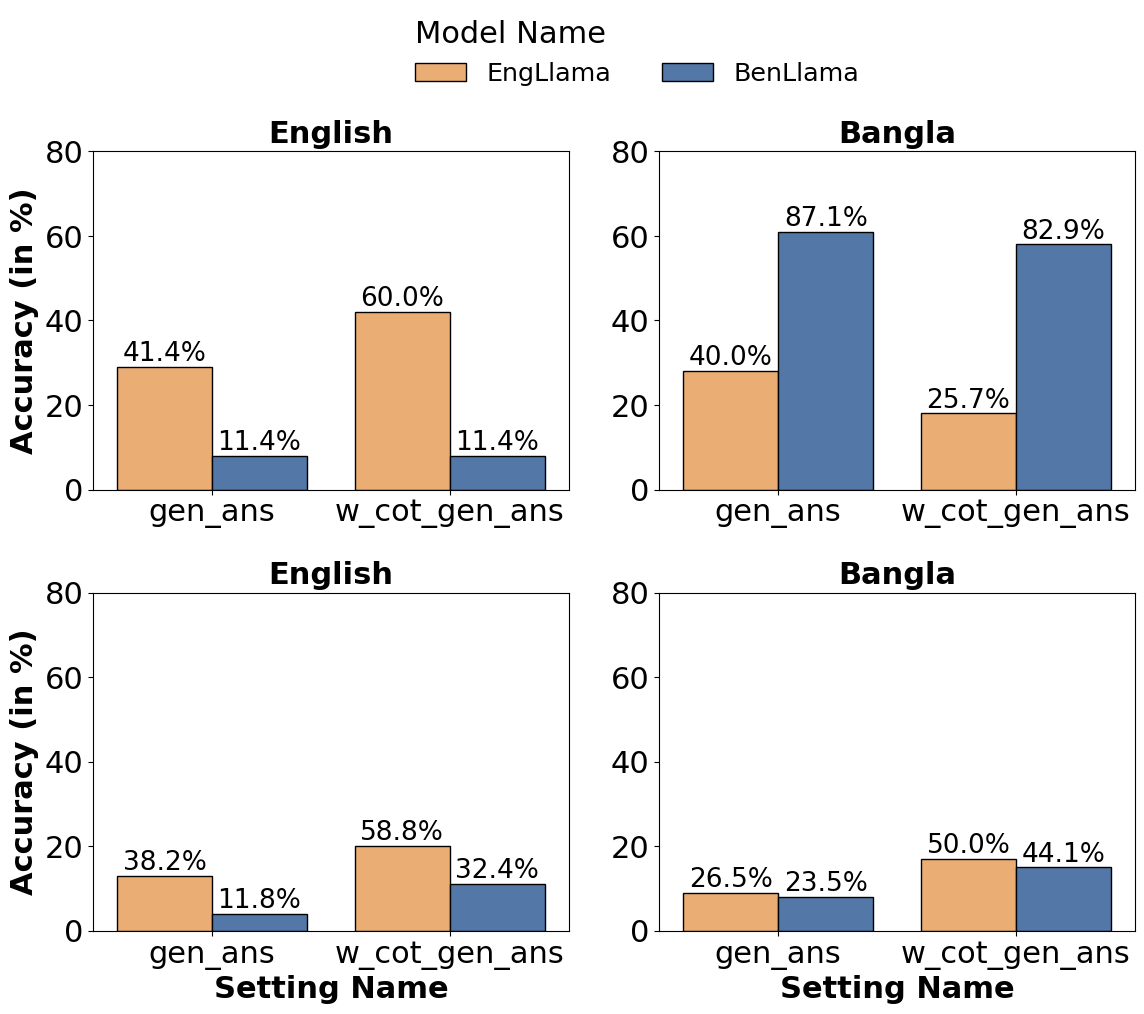

Saved all plots on a single PDF page to: /content/drive/MyDrive/Research/Mirage CoT/Results/Viz/all_ques_type.pdf


In [ ]:
if "__main__":

  ''' For easy access

  model_names = ["meta-llama/Llama-3.2-1B-Instruct", "BanglaLLM/BanglaLLama-3.2-1b-bangla-alpaca-orca-instruct-v0.0.1"]
  langs = ["eng", "ben"]
  setting_names = ["gen_ans", "gen_cot_ans", "w_cot_gen_ans"]

  '''

  ''' Init Path '''
  unique_question_id_set_path = "/content/drive/MyDrive/Research/Mirage CoT/Dataset/reveal_preprocess_prompting_set.csv"
  reveal_bangla_path = "/content/drive/MyDrive/Research/Mirage CoT/Dataset/reveal-bangla.csv"

  ''' Importing sets '''
  # unique_question_id_set = import_dataset( unique_question_id_set_path )
  # reveal_bangla = import_dataset( reveal_bangla_path )

  ''' Saving all models gen output on all setting on a unique_question_id_set extended csv file '''
  '''This line of Code will be run on Habrok Only'''
  # merged_data = merge_gen_outputs_to_dataset( unique_question_id_set_path, reveal_bangla_path, unique_question_id_set, reveal_bangla, "only_ans" )

  ''' All Combination Substring Evaluation '''
  verdict_analyzer = VerdictAnalyzer()
  # verdict_analyzer.visualize_combined_results()
  verdict_analyzer.visualize_dif_ques_type_results()

  ''' Sanity Checks '''
  # sanity_check_item( "meta-llama/Llama-3.2-1B-Instruct", "meta-llama/Llama-3.2-1B-Instruct", "ben", "eng", "gen_cot_ans", "gen_cot_ans", reveal_bangla )

  '''gen_ans VS w_cot_gen_ans analysis'''
  # process_wrong_gen_ans_bt_corrct_w_cot_gen_ans()
